<a href="https://colab.research.google.com/github/criscotero/riesgo-hospitalario-modelado/blob/main/Filter_Mutual_Information.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Relevant Data**
- Over the waves, the participants mostly remain the same. According to the codebook, only a few new individuals are added in each wave.
- Based on the EDA, the data must be filtered using the following criteria:
  1. Include only **elderly individuals** (age 50 years or older).
  2. Include only **living individuals** (exclude those who passed away during the waves).
  3. Include only **in-person surveyed participants** (exclude observations based on reports from family members or relatives).
  4. Include only **Respondents** (specific details not visible in this section).

- **Additional Notes**:  
  - Filtering will only consider the last wave (wave 5) because of the significant time gap between waves, which are non-consecutive (approximately three years apart).  
  - **Reason for choosing wave 5**:  
    - Elderly health conditions tend to change annually. Considering this, using wave 5 provides the most recent and reliable data for analyzing meaningful health changes.  


### **Step-by-Step for Exploratory Data Analysis (EDA) and Feature Selection Using Filters**

---

### **1. Understand the Context and Requirements**
1. **Business Objective**: Predict the risk (probability) of hospitalization in older adults.
2. **Data Characteristics**:
   - Panel data: cross-sectional + time series data.
   - Irregular time intervals between waves.
   - Focus on the last wave (wave 5) for prediction due to its relevance and recency.
   - Target variable is highly imbalanced (1.4/8.6).

---

### **2. Exploratory Data Analysis (EDA)**

#### **A. Data Understanding and Delimitation**
1. **Identify the Observation Subjects**:
   - Initial subjects: Respondent (R), Spouse (S), Home (H).
   - Justification: Work only with `Respondent (R)` as their personal characteristics are directly relevant for prediction.
2. **Age Filtering**:
   - Filter older adults: retain only individuals aged 50 years or older.
3. **Available Variables**:
   - Approximately 469 variables after the initial delimitation.

#### **B. Missing Data Analysis**
1. Calculate the percentage of missing values for each column.
2. Visualize missing data:
   - Create a bar plot showing the percentage of missing values by column.
3. **Nature of Missing Data**:
   - Identified as MNAR (Missing Not At Random).
   - Strategy: Treat missing values (`NaN`) as an additional category and let the model determine their relevance.

#### **C. Data Imbalance Analysis**
1. Evaluate the imbalance in the target variable.
2. **Strategy for Imbalanced Data**:
   - Use oversampling techniques like **SMOTE** (Synthetic Minority Oversampling Technique) to balance the dataset.

#### **D. Analysis of Categorical and Numerical Variables**
1. Identify:
   - **Numerical Variables**: Example, hospitalization costs.
   - **Categorical Variables**: Represent 90% of the dataset (binary: 0/1).
2. Identify **cardinality** (unique values):
   - Remove variables with extremely high or low cardinality.

#### **E. Correlation Analysis**
1. Calculate correlation for categorical variables:
   - Use **Cramer’s V** to measure relationships between categorical variables.
2. Calculate correlations for numerical variables:
   - Use Pearson or Spearman correlation.

---

### **3. Feature Selection Using Filters**

#### **A. Filter-Based Feature Selection Methods**
1. **Remove Low Variability**:
   - Eliminate constant or near-constant variables (e.g., columns with variance close to 0).
   - Calculate the variance for each variable and filter based on a low threshold.
2. **Correlation Analysis**:
   - Use correlation to identify redundant variables.
   - Keep only one variable from highly correlated pairs (threshold > 0.8).
3. **Statistical Measures**:
   - Apply techniques such as **Chi-square** (for categorical variables) or **ANOVA** (for numerical variables) to evaluate the relationship between features and the target variable.
4. **Mutual Information**:
   - Calculate mutual information between each variable and the target to measure nonlinear dependencies.
5. **Univariate Selection**:
   - Select the best variables based on univariate statistical tests.

#### **B. Importance-Based Reduction**
1. Use a baseline model like Random Forest to compute feature importance.
2. Select the top 30 variables with the highest importance scores.

---

### **4. Proposed Workflow**

1. **EDA**:
   - Analyze missing data, imbalance, and general characteristics of the dataset.
2. **Initial Filtering**:
   - Filter by age (>50 years), remove low-variance variables, and focus only on Respondents (R).
3. **Preprocessing**:
   - Balance the dataset using SMOTE.
   - Impute or categorize missing values.
4. **Feature Selection**:
   - Apply filter methods (variance, correlation, ANOVA, Chi-square, mutual information).
   - Reduce to the top 30 best features.
5. **Baseline Model**:
   - Train a baseline model with the selected features to evaluate performance.
6. **Fine-Tuning**:
   - Adjust hyperparameters and optimize the final model.



In [89]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

#"content/drive/MyDrive/shared-with-me/anyoneAI_FP"

if IN_COLAB:
    ROOT_DIR = "/content/drive/MyDrive/AY/"
    %cd $ROOT_DIR


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AY


In [90]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from scipy.stats import chi2_contingency



def handle_missing_values(df, numeric_placeholder=-999, categorical_placeholder='Missing'):
    """
    Replace missing values in numerical and categorical columns.
    Args:
        df (pd.DataFrame): The input dataset.
        numeric_placeholder: Placeholder for missing numerical values.
        categorical_placeholder: Placeholder for missing categorical values.
    Returns:
        pd.DataFrame: The dataframe with missing values handled.
    """
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(numeric_placeholder)
        else:  # Categorical columns
            df[col] = df[col].fillna(categorical_placeholder)
    return df


def balance_data(X, y):
    """
    Balance the dataset using SMOTE.
    Args:
        X (pd.DataFrame): Features dataframe.
        y (pd.Series): Target variable.
    Returns:
        tuple: Balanced features (X) and target (y).
    """
    smote = SMOTE(random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    return X_balanced, y_balanced


def filter_by_age(df, age_column='r5agey', age_threshold=50):
    """
    Filter rows by age threshold.
    Args:
        df (pd.DataFrame): The input dataset.
        age_column (str): The column containing age data.
        age_threshold (int): The minimum age to include.
    Returns:
        pd.DataFrame: Filtered dataset.
    """
    return df[df[age_column] >= age_threshold]



def remove_low_variability(df, threshold=0.01):
    """
    Remove features with low variance after ensuring all columns are numeric.
    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (float): Variance threshold.
    Returns:
        pd.DataFrame: Dataframe with low-variance features removed.
    """
    # Ensure all columns are numeric
    df_numeric = df.select_dtypes(include=['number'])

    # Apply VarianceThreshold
    selector = VarianceThreshold(threshold=threshold)
    df_filtered = selector.fit_transform(df_numeric)

    # Return filtered DataFrame with selected columns
    return pd.DataFrame(df_filtered, columns=df_numeric.columns[selector.get_support()])


def handle_categorical_cardinality(df, max_cardinality=100, min_cardinality=2):
    """
    Remove categorical features with very high or very low cardinality.
    Args:
        df (pd.DataFrame): Input dataframe.
        max_cardinality (int): Maximum allowed unique values.
        min_cardinality (int): Minimum allowed unique values.
    Returns:
        pd.DataFrame: Dataframe with filtered categorical variables.
    """
    for col in df.select_dtypes(include=['object']).columns:
        unique_values = df[col].nunique()
        if unique_values > max_cardinality or unique_values < min_cardinality:
            df = df.drop(columns=[col])
    return df


def calculate_v_cramer(df, categorical_columns):
    """
    Calculate V Cramer correlation for categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    Returns:
        pd.DataFrame: Correlation matrix for categorical variables.
    """
    def v_cramer(confusion_matrix):
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        return np.sqrt(phi2 / min(k - 1, r - 1))

    corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                confusion_matrix = pd.crosstab(df[col1], df[col2])
                corr_matrix.loc[col1, col2] = v_cramer(confusion_matrix)
    return corr_matrix


def filter_alive_respondents(df, status_column='r5iwstat', alive_value='1.Resp, alive'):
    """
    Filter the dataset to include only alive respondents based on the R5IWSTAT variable.

    Args:
        df (pd.DataFrame): Input dataset.
        status_column (str): Column name indicating respondent's status (default is 'R5IWSTAT').
        alive_value (int): Value in the status column that represents 'alive' (default is 1).

    Returns:
        pd.DataFrame: Filtered dataset containing only alive respondents.
    """
    # Filter rows where the status column equals the alive value
    filtered_df = df[df[status_column] == alive_value]
    return filtered_df



def analyze_and_handle_missing_values(df, threshold=30):
    """
    Analyze missing values, visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        threshold (int): Percentage threshold for dropping columns (default: 30).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    # Visualize missing data
    plt.figure(figsize=(10, 6))
    missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Columns", fontsize=12)
    plt.ylabel("Percentage of Missing Values", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

    # Drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    print(f"Columns dropped (>{threshold}% missing): {list(columns_to_drop)}")

    df = df.drop(columns=columns_to_drop)
    return df


import matplotlib.pyplot as plt

def remove_columns_with_missing_values(df, missing_values_threshold=30, visualize=True):
    """
    Analyze missing values, optionally visualize them, and drop columns exceeding the threshold.

    Args:
        df (pd.DataFrame): Input dataframe.
        missing_values_threshold (int): Percentage threshold for dropping columns (default: 30).
        visualize (bool): Whether to visualize the missing data (default: True).

    Returns:
        pd.DataFrame: Dataframe after dropping columns with excessive missing values.
    """
    # Calculate the percentage of missing values
    missing_percentage = (df.isnull().sum() / len(df)) * 100

    if visualize:
        # Visualize missing data with highlighting for columns exceeding the threshold
        plt.figure(figsize=(10, 6))
        colors = ['red' if val > missing_values_threshold else 'skyblue' for val in missing_percentage]
        missing_percentage.sort_values(ascending=False).plot(kind='bar', color=colors)
        plt.axhline(y=missing_values_threshold, color='gray', linestyle='--', linewidth=1.5, label=f'Threshold ({missing_values_threshold}%)')
        plt.title("Percentage of Missing Values by Column", fontsize=16)
        plt.xlabel("Columns", fontsize=12)
        plt.ylabel("Percentage of Missing Values", fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.show()

    # Identify and drop columns exceeding the threshold
    columns_to_drop = missing_percentage[missing_percentage > missing_values_threshold].index
    print(f"Dropping {len(columns_to_drop)} columns (>{missing_values_threshold}% missing): {list(columns_to_drop)}")

    # Drop the columns
    filtered_df = df.drop(columns=columns_to_drop)

    # Print updated shape
    print(f"Updated dataframe shape: {filtered_df.shape}")

    return filtered_df



def cramers_v(x, y):
    """
    Calculate Cramér's V statistic for categorical association.
    Args:
        x (pd.Series): First categorical variable.
        y (pd.Series): Second categorical variable.
    Returns:
        float: Cramér's V statistic.
    """
    # Ensure inputs are strings
    x, y = x.astype(str), y.astype(str)

    contingency_table = pd.crosstab(x, y)
    if contingency_table.size == 0:  # Handle empty tables
        return np.nan

    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape

    # Handle cases where min(k-1, r-1) is 0
    if min(k - 1, r - 1) == 0:
        return np.nan

    return np.sqrt(phi2 / min(k - 1, r - 1))


def cramers_v_matrix(df):
    """
    Create a Cramér's V correlation matrix for all categorical variables.
    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
    Returns:
        pd.DataFrame: Cramér's V correlation matrix.
    """
    # Automatically filter categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Ensure all categorical columns are strings
    df = df[categorical_columns].astype(str)

    cramers_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                cramers_matrix.loc[col1, col2] = 1.0
            else:
                cramers_matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    return cramers_matrix.astype(float)


def remove_redundant_features_cramers(df, cramers_matrix, threshold=0.8, target_column='r5hosp1y'):
    """
    Use a precomputed Cramér's V matrix to identify and remove redundant categorical features,
    ensuring the target variable is not removed.

    Args:
        df (pd.DataFrame): Dataframe containing categorical variables.
        cramers_matrix (pd.DataFrame): Precomputed Cramér's V correlation matrix.
        threshold (float): Threshold for Cramér's V to consider redundancy.
        target_column (str): The target variable that must not be removed.

    Returns:
        pd.DataFrame: Dataframe with redundant features removed.
    """
    # Identify redundant variables
    redundant_vars = set()
    for col1 in cramers_matrix.columns:
        for col2 in cramers_matrix.columns:
            if col1 != col2 and cramers_matrix.loc[col1, col2] > threshold:
                # Ensure the target variable is not added to redundant features
                if col2 != target_column:
                    redundant_vars.add(col2)

    # Drop redundant variables while preserving the target variable
    reduced_df = df.drop(columns=redundant_vars, errors='ignore')
    print(f"Removed {len(redundant_vars)} redundant features: {redundant_vars}")
    return reduced_df




def handle_all_missing_as_category(df, target_column='r5hosp1y', missing_label='Missing', numerical_fill_value=-1):
    """
    Treat missing values (NaN) in all columns as an additional category for categorical columns
    and assign a default value (-1) for numerical columns, excluding the target column.

    Args:
        df (pd.DataFrame): The input dataset.
        target_column (str): The column to exclude from missing value handling.
        missing_label (str): The label to replace missing values with in categorical columns (default: 'Missing').
        numerical_fill_value (int or float): The value to replace missing values with in numerical columns (default: -1).

    Returns:
        pd.DataFrame: The dataset with missing values handled appropriately.
    """
    df = df.copy()

    for col in df.columns:
        if col == target_column:
            # Skip the target column
            continue
        if df[col].dtype.name == 'category' or df[col].dtype == object:
            # Handle categorical columns
            if df[col].dtype.name == 'category':
                # Add the missing label to the categories if the column is categorical
                df[col] = df[col].cat.add_categories([missing_label])
            # Replace missing values with the missing label
            df[col] = df[col].fillna(missing_label)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Handle numerical columns
            df[col] = df[col].fillna(numerical_fill_value)

    return df



def extract_wave_data(df, wave_number):
    """
    Extract variables from a specific wave based on the second character of their names.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the second character
    of any variable refers to the particular wave the variable is encoding.

    Parameters:
    - df: DataFrame
    - wave_number: int or str, wave identifier (1, 2, 3, 4, 5; the character 'a' denotes a cross-wave variable)

    Returns:
    - DataFrame with columns for the specified wave.
    """
    # Select variables from a specific wave
    specific_wave_columns = [col for col in df.columns if len(
        col) > 1 and col[1] == str(wave_number)]

    # Select cross-wave variables
    cross_wave = [col for col in df.columns if len(col) > 1 and col[1] == 'a']

    # Combine specific and common variables
    wave_columns = list(set(specific_wave_columns + cross_wave))

    return df[wave_columns]


def extract_respondent_data(df):
    """
    Extract variables from respondent.
    Section 1.4 of the harmonized MHAS documentation (version C.2) explains that the first character
    of any variable refers to the particular individual referred to by the variable.

    Parameters:
    - df: DataFrame

    Returns:
    - DataFrame with columns for respondent.
    """
    return df[[col for col in df.columns if col.startswith('r')]]


def remove_missing_values(df, column_name):
    """
    Remove all rows matching missing values from a specified column

    Parameters:
    - df: DataFrame
    - column_name: name of column to search for missing values

    Returns:
    - DataFrame with no missing values for the specified column.
    """

    df = df[df[column_name].notna()]

    return df


def missing_value_ratio(df, ratio):
    """
    Identify variables with the specified missing value ratio

    Parameters:
    - df: DataFrame
    - ratio: proportion of missing values

    Returns:
    - List of columns with a ratio equal to or higher than the one specified by the user.
    """

    # Identify categorical columns
    # categorical_columns = df.select_dtypes(
    # include=['object', 'category']).columns

    # Identify and store columns with the specified missing value ratio
    columns_matching_missing_value_ratio = [
        col for col in df.columns
        if df[col].isnull().mean() > ratio
    ]

    print(f"Variables with a missing value ratio higher than {ratio}: {columns_matching_missing_value_ratio}")
    print(f"Count of variables with a missing ratio higher than {ratio}: {len(columns_matching_missing_value_ratio)}")

    return columns_matching_missing_value_ratio




def save_categorical_features_with_values(df: pd.DataFrame, file_name: str):
    """
    Saves the unique values of categorical features in a DataFrame to a text file.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        file_name (str): The name of the text file to save the output.
    """
    try:
        # Select only categorical columns
        categorical_cols = df.select_dtypes(include=['object']).columns
        file_path = os.path.join(DATASET_ROOT_PATH, file_name)
        # Open the file for writing
        with open(file_path, 'w') as f:
            for column in df.columns:
                # Get the unique values of the column
                unique_values = df[column].unique()
                # Limit the number of values shown for readability
                unique_values_preview = unique_values[:10]  # Show up to 10 values
                # Write the feature name and unique values to the file
                f.write(f"{column}: {list(unique_values_preview)}\n\n")

        print(f"Categorical features with their unique values have been saved to '{file_name}'")
    except Exception as e:
        print(f"An error occurred: {e}")




In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_missing_values(df):
    """
    Plot the percentage of missing values for each column in the dataset.
    Args:
        df (pd.DataFrame): Input dataframe.
    """
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")
    plt.title("Percentage of Missing Values by Column", fontsize=16)
    plt.xlabel("Percentage of Missing Values", fontsize=12)
    plt.ylabel("Columns", fontsize=12)
    plt.show()

def plot_class_distribution(target):
    """
    Plot the distribution of the target variable to visualize class imbalance.
    Args:
        target (pd.Series): Target variable.
    """
    class_counts = target.value_counts()

    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")
    plt.title("Class Distribution of Target Variable", fontsize=16)
    plt.xlabel("Classes", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.show()

    print(f"Class Distribution:\n{class_counts}")
    print(f"Class Ratios:\n{class_counts / class_counts.sum() * 100}")


def plot_numerical_distributions(df, numeric_columns):
    """
    Plot the distributions of numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    for col in numeric_columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(df[col].dropna(), kde=True, bins=30, color="skyblue")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.show()


def plot_categorical_distributions(df, categorical_columns):
    """
    Plot the distributions of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    for col in categorical_columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(x=df[col], order=df[col].value_counts().index, palette="muted")
        plt.title(f"Distribution of {col}", fontsize=16)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Count", fontsize=12)
        plt.xticks(rotation=45)
        plt.show()


def plot_correlation_matrix(df, numeric_columns):
    """
    Plot a heatmap of correlations between numerical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        numeric_columns (list): List of numerical column names.
    """
    corr_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Matrix", fontsize=16)
    plt.show()


def plot_v_cramer_matrix(df, categorical_columns):
    """
    Plot a heatmap of V Cramer correlations between categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    corr_matrix = calculate_v_cramer(df, categorical_columns)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("V Cramer Correlation Matrix", fontsize=16)
    plt.show()


def plot_categorical_cardinality(df, categorical_columns):
    """
    Plot the cardinality (number of unique values) of categorical variables.
    Args:
        df (pd.DataFrame): Input dataframe.
        categorical_columns (list): List of categorical column names.
    """
    cardinality = {col: df[col].nunique() for col in categorical_columns}
    cardinality = pd.Series(cardinality).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=cardinality.values, y=cardinality.index, palette="cool")
    plt.title("Cardinality of Categorical Variables", fontsize=16)
    plt.xlabel("Number of Unique Values", fontsize=12)
    plt.ylabel("Variables", fontsize=12)
    plt.show()


# Load the dataset

In [92]:

file_path = 'H_MHAS_c2.dta'
print("Loading the dataset...")
raw_df = pd.read_stata(file_path)
print(f"Dataset loaded successfully with shape: {raw_df.shape}")
print("Preview of the dataset:")
display(raw_df.head())  # Use display() for better rendering in Jupyter Notebook

Loading the dataset...
Dataset loaded successfully with shape: (26839, 5241)
Preview of the dataset:


,codent01,codent03,ps3,ent2,np,unhhidnp,rahhidnp,tipent_01,tipent_03,tipent_12,...,s4satlife_m,s5satlife_m,r3satlifez,r4satlifez,r5satlifez,s3satlifez,s4satlifez,s5satlifez,r2cantril,s2cantril
0,1.Selected person,1.Selected person in 2001,1.0,1.0,10,110.0,110,"12.Direct, second interview","12.Direct, second interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,NaN,NaN,1.510731,NaN,NaN,1.0,NaN
1,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,120.0,120,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,NaN,NaN,1.510731,-0.387025,-0.393398,1.510731,NaN,NaN,NaN,1.0
2,1.Selected person,1.Selected person in 2001,1.0,1.0,10,210.0,210,"11.Direct, first interview","22.Proxy, second interview","1.Direct, follow-up interview",...,NaN,NaN,-0.397267,-0.387025,-0.393398,NaN,NaN,NaN,NaN,5.0
3,2.Spouse of selected person,2.Spouse of selected person in 2001,2.0,2.0,20,220.0,220,"12.Direct, second interview","11.Direct, first interview","3.Proxy, follow-up interview",...,1.Agree,NaN,NaN,NaN,NaN,-0.397267,-0.387025,NaN,5.0,NaN
4,1.Selected person,1.Selected person in 2001,1.0,1.0,10,310.0,310,"11.Direct, first interview","11.Direct, first interview","1.Direct, follow-up interview",...,1.Agree,1.Agree,-0.397267,-0.387025,-0.393398,-0.397267,-0.387025,-0.393398,1.0,NaN



# Step 1: Filter data from Wave 5

In [93]:
print("\nFiltering data for Wave 5...")
wave_5_df = extract_wave_data(raw_df, "5")
print(f"Wave 5 dataframe shape: {wave_5_df.shape}")


Filtering data for Wave 5...
Wave 5 dataframe shape: (26839, 1004)


# Step 2: Include only direct respondents

In [94]:
print("\nFiltering data for direct respondents only...")
wave_5_respondents_df = extract_respondent_data(wave_5_df)
print(f"Wave 5 respondent-only dataframe shape: {wave_5_respondents_df.shape}")


Filtering data for direct respondents only...
Wave 5 respondent-only dataframe shape: (26839, 469)



# Step 3: Filter for elderly individuals aged 50 or older

In [95]:
print("\nFiltering data for elderly individuals (aged 50+)...")
elderly_individuals_df = filter_by_age(wave_5_respondents_df)
print(f"Wave 5 elderly individuals dataframe shape: {elderly_individuals_df.shape}")


Filtering data for elderly individuals (aged 50+)...
Wave 5 elderly individuals dataframe shape: (15868, 469)



# Step 4: Exclude individuals who passed away

In [96]:
print("\nExcluding individuals who passed away during the waves...")
alive_individual_df = filter_alive_respondents(elderly_individuals_df)
print(f"Wave 5 alive individuals dataframe shape: {alive_individual_df.shape}")


Excluding individuals who passed away during the waves...
Wave 5 alive individuals dataframe shape: (15868, 469)


# Step 5: Visualize missing values


Visualizing missing values...


<ipython-input-91-50447ff25624>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette="viridis")


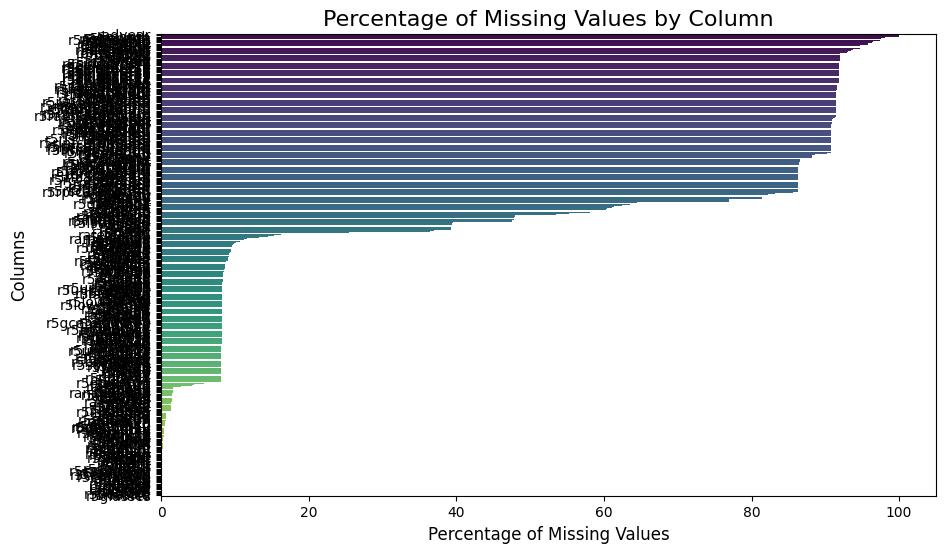

In [97]:
print("\nVisualizing missing values...")
plot_missing_values(alive_individual_df)


# Step 6: Remove columns with more than 30% missing values


Removing columns with more than 30% missing values...


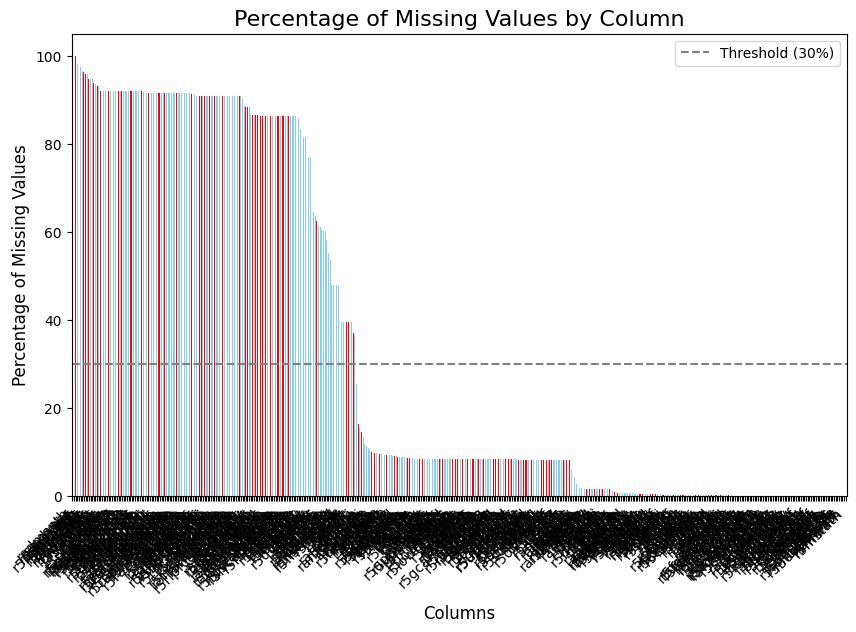

Dropping 172 columns (>30% missing): ['r5recstrok', 'r5ripfcaren', 'r5rscaredpmm', 'r5rccarehr', 'r5reccancr', 'r5breast', 'r5ciqscore15', 'r5rccarehrm', 'r5riscaredpmm', 'r5rascaredpm', 'r5raccaredpm', 'r5rircaredpmm', 'r5rechrtatt', 'r5paina', 'r5rcany', 'r5haluc', 'r5rscaredpm', 'r5walkhlp', 'r5moneyhlp', 'r5rjudg', 'r5riscare', 'r5rifcare', 'r5strtsmok', 'r5ripfcaredpmm', 'r5rafcaren', 'r5jcten', 'r5ciqscore12', 'r5rccaren', 'r5rircarehrm', 'r5ciqscore10', 'r5arthlmt', 'r5unemp', 'r5jredhr', 'r5ripfcarehrm', 'r5riscarehrm', 'r5penic', 'r5jrsleft', 'r5rifcaredpmm', 'r5ciqscore3', 'r5rafcarehr', 'r5hrtatlmt', 'r5rircaren', 'r5rfcarehr', 'r5rascarehrm', 'r5rarcarehrm', 'r5raccarehrm', 'r5ripfcarehr', 'r5prmem', 'r5rarcaredpm', 'r5rpfcarehrm', 'r5rfcaredpm', 'r5ciqscore6', 'r5riccarehrm', 'r5lifein_m', 'r5ciqscore8', 'r5resplmt', 'r5riscaredpm', 'r5rascarehr', 'r5riccaredpmm', 'r5rrcarehrm', 'r5rarcaredpmm', 'r5rrcarehr', 'r5raccaren', 'r5racany', 'r5rrcaredpm', 'r5lstmnspd', 'r5slfemp

In [98]:
missing_percentage_threshold = 30
print(f"\nRemoving columns with more than {missing_percentage_threshold}% missing values...")
df_filtered_by_missing_values = remove_columns_with_missing_values(alive_individual_df, missing_percentage_threshold)
print(f"Dataframe shape after removing columns with excessive missing values: {df_filtered_by_missing_values.shape}")

# Step 7: Handle the target column (r5hosp1y)

In [99]:
target_column = 'r5hosp1y'
target_mapping = {'1.Yes': 1, '0.No': 0}
print(f"\nProcessing the target column '{target_column}'...")
cleaned_df = (
    df_filtered_by_missing_values
    .dropna(subset=[target_column])  # Remove rows with missing target values
    .assign(**{target_column: df_filtered_by_missing_values[target_column].map(target_mapping)})  # Map to 1s and 0s
)
print(f"Dataframe shape after processing target column: {cleaned_df.shape}")


Processing the target column 'r5hosp1y'...
Dataframe shape after processing target column: (15807, 297)


# Step 8: Handle missing values for all columns (excluding the target column)

In [100]:
print("\nHandling missing values for all columns...")
final_data = handle_all_missing_as_category(cleaned_df, target_column=target_column)
print(f"Final dataset shape: {final_data.shape}")


Handling missing values for all columns...
Final dataset shape: (15807, 297)



# Step 9: Save the cleaned dataset

In [101]:
output_path = 'cleaned_dataset.csv'
final_data.to_csv(output_path, index=False)
print(f"\nCleaned dataset saved successfully to {output_path}")


Cleaned dataset saved successfully to cleaned_dataset.csv


<ipython-input-91-50447ff25624>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="coolwarm")


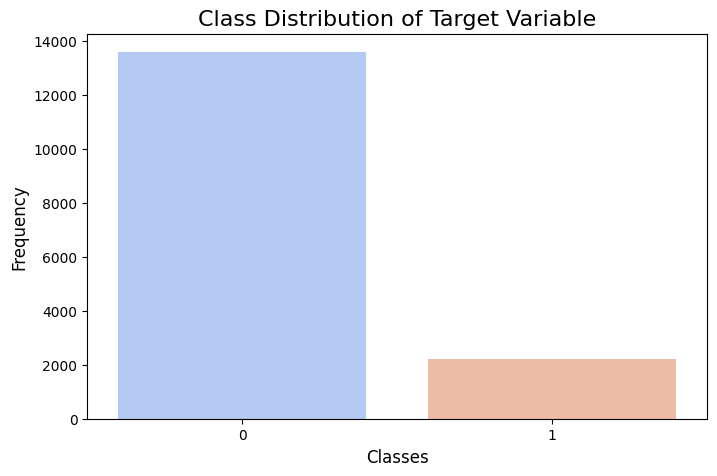

Class Distribution:
r5hosp1y
0    13595
1     2212
Name: count, dtype: int64
Class Ratios:
r5hosp1y
0    86.0062
1    13.9938
Name: count, dtype: float64


In [102]:
data = final_data.copy()

plot_class_distribution(data ['r5hosp1y'])

# Feature Selection using Mutual Information (MI)

Reduce the number of features by selecting only the most relevant ones based on their dependency with the target variable.

## 1. Prepare the data

Handle missing values (imputation or categorization).**texto en negrita**

In [103]:
missing_values = (data.isnull().sum() / len(data)) * 100
missing_values = missing_values[missing_values > 0]  # Filtrar solo columnas con NaN

print("\nSummary of missing values:")
print(missing_values.describe())


Summary of missing values:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64


Convert categorical variables into numerical format.

In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [105]:
# Define target variable
TARGET_VAR = "r5hosp1y"

data = final_data.copy()


# Identify categorical features
cat_cols = data.select_dtypes(include=['category', 'object']).columns
cat_cols = cat_cols.drop(TARGET_VAR, errors='ignore')  # Remove target from categorical columns

# Copy categorical data
X_cat = data[cat_cols].copy()

# Encode categorical variables
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col])  # Convert categories to numbers
    label_encoders[col] = le  # Store encoders for reference

print("✅ Categorical variables encoded successfully!")



✅ Categorical variables encoded successfully!


# 2. Compute Mutual Information (MI)

Mutual Information measures the dependency between each feature and the target variable. A higher MI score means the feature contains more information about the target.

In [106]:
# Compute MI for categorical features
mi_scores = mutual_info_classif(X_cat, data[TARGET_VAR], discrete_features=True, random_state=42)

# Store results in a DataFrame
mi_df = pd.DataFrame({'Feature': X_cat.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)  # Sort by importance

# Display top 30 most informative features
print(mi_df.head(30))


         Feature  MI Score
131     rahhidnp  0.404851
113     r5lbrf_m  0.019366
52   r5oophosf1y  0.017153
155    r5adlaa_m  0.016676
46       r5walks  0.015543
11      r5walksa  0.015502
168    r5grossaa  0.015303
129       r5lift  0.015113
71       r5lifta  0.015079
27         r5jog  0.014534
119       r5push  0.014470
4     r5adltot6a  0.014459
125      r5pusha  0.014410
102   r5doctor1y  0.014225
206    r5mobilaa  0.014185
105      r5adlaa  0.014081
170  r5uppermoba  0.014041
34    r5adlfivea  0.013761
188    r5nagi10a  0.013566
175     r5nagi8a  0.013294
76      r5walkra  0.013258
6    r5mobilseva  0.013221
109      r5batha  0.012777
64       r5clims  0.012751
123      r5clim1  0.012639
25      r5clim1a  0.012533
174      r5stoop  0.012518
77   r5iadlfoura  0.012506
93     r5lgmusaa  0.012488
5         r5joga  0.012474


## 3. Visualize the MI Scores

 A bar plot helps us see which features contribute the most to the prediction.

<ipython-input-107-7436010d200c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_df["MI Score"][:20], y=mi_df["Feature"][:20], palette="coolwarm")


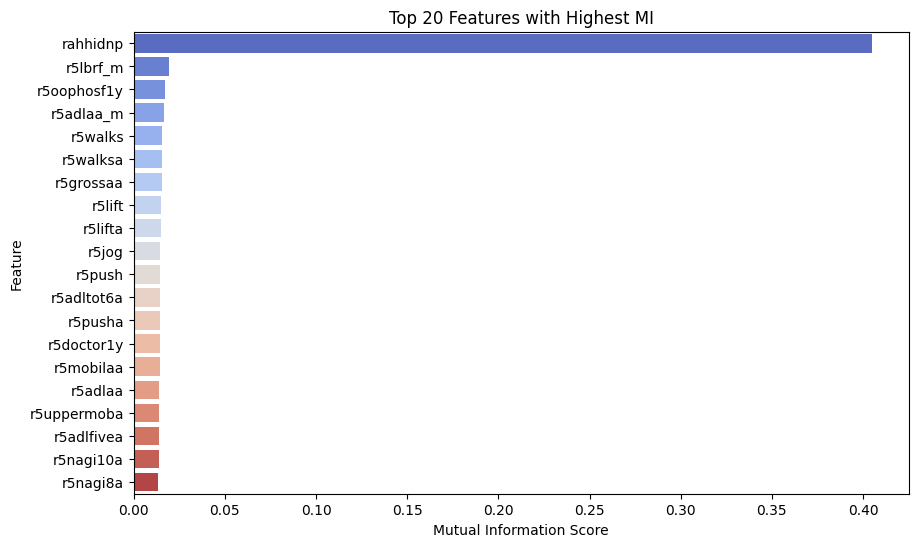

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(x=mi_df["MI Score"][:20], y=mi_df["Feature"][:20], palette="coolwarm")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Top 20 Features with Highest MI")
plt.show()


## 4. Select the Most Relevant Features

In [108]:
# Select features with MI score above threshold
mi_df_cat = mi_df[mi_df["MI Score"] > 0.01]["Feature"].tolist()

# Keep only selected features
X_selected = X_cat[mi_df_cat]

print(f"✅ Selected {len(mi_df_cat)} features from {X_cat.shape[1]}")
mi_df_cat


✅ Selected 49 features from 211


['rahhidnp',
 'r5lbrf_m',
 'r5oophosf1y',
 'r5adlaa_m',
 'r5walks',
 'r5walksa',
 'r5grossaa',
 'r5lift',
 'r5lifta',
 'r5jog',
 'r5push',
 'r5adltot6a',
 'r5pusha',
 'r5doctor1y',
 'r5mobilaa',
 'r5adlaa',
 'r5uppermoba',
 'r5adlfivea',
 'r5nagi10a',
 'r5nagi8a',
 'r5walkra',
 'r5mobilseva',
 'r5batha',
 'r5clims',
 'r5clim1',
 'r5clim1a',
 'r5stoop',
 'r5iadlfoura',
 'r5lgmusaa',
 'r5joga',
 'r5stoopa',
 'r5shop',
 'r5shopa',
 'r5lowermoba',
 'r5beda',
 'r5hearte',
 'r5climsa',
 'r5cholst',
 'r5adlwaa',
 'r5toilta',
 'r5walk1',
 'r5fineaa',
 'r5walk1a',
 'r5hltc',
 'r5meals',
 'r5shlt',
 'r5mealsa',
 'r5dress',
 'r5dressa']

## 5. Compute MI for Numerical Features

Use mutual_info_classif (for classification) or mutual_info_regression (for regression).

In [109]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

# Identify numerical features
num_cols = data.select_dtypes(include=['int64', 'float64']).columns
num_cols = num_cols.drop(TARGET_VAR, errors='ignore')  # Remove target variable

# Compute MI for numerical features
mi_scores_num = mutual_info_classif(data[num_cols], data[TARGET_VAR], random_state=42)  # Use mutual_info_regression if target is numerical

# Store results in a DataFrame
mi_df_num = pd.DataFrame({'Feature': num_cols, 'MI Score': mi_scores_num})
mi_df_num = mi_df_num.sort_values(by="MI Score", ascending=False)

# Display top numerical features
print(mi_df_num.head(20))


       Feature  MI Score
3   r5hspnit1y  0.404883
49  r5doctim1y  0.026141
59     r5nagi8  0.020946
17      r5adla  0.020633
55    r5mobila  0.020065
48    r5adla_m  0.017490
19  r5mobilsev  0.016726
52    r5grossa  0.016239
21    r5lgmusa  0.015730
23   r5adltot6  0.014213
60  r5lowermob  0.013922
32    r5nagi10  0.013684
31  r5uppermob  0.013102
41     r5finea  0.012291
47   r5adlfive  0.012173
34  r5iadlfour  0.011077
45    r5cesd_m  0.010780
2      r5adlwa  0.010589
50    r5adlwam  0.009090
36     r5henum  0.007691


In [110]:

# Store results in a DataFrame
mi_df_num = pd.DataFrame({'Feature': num_cols, 'MI Score': mi_scores_num})
mi_df_num = mi_df_num.sort_values(by="MI Score", ascending=False)

# Filter features with MI Score > 0.1
selected_num_features = mi_df_num[mi_df_num["MI Score"] > 0.1]["Feature"].tolist()

# Create a new DataFrame with only selected numerical features
X_num_selected = data[selected_num_features]

print(f"✅ Selected {len(selected_num_features)} numerical features from {len(num_cols)}")
print(selected_num_features)  # Show selected features

✅ Selected 1 numerical features from 61
['r5hspnit1y']


Combine MI Scores for Numerical and Categorical Features

In [111]:
# Merge numerical and categorical MI results
mi_df = pd.concat([mi_df_num, mi_df])

# Sort by MI Score
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

# Display top features
print(mi_df.head(30))


         Feature  MI Score
3     r5hspnit1y  0.404883
131     rahhidnp  0.404851
49    r5doctim1y  0.026141
59       r5nagi8  0.020946
17        r5adla  0.020633
55      r5mobila  0.020065
113     r5lbrf_m  0.019366
48      r5adla_m  0.017490
52   r5oophosf1y  0.017153
19    r5mobilsev  0.016726
155    r5adlaa_m  0.016676
52      r5grossa  0.016239
21      r5lgmusa  0.015730
46       r5walks  0.015543
11      r5walksa  0.015502
168    r5grossaa  0.015303
129       r5lift  0.015113
71       r5lifta  0.015079
27         r5jog  0.014534
119       r5push  0.014470
4     r5adltot6a  0.014459
125      r5pusha  0.014410
102   r5doctor1y  0.014225
23     r5adltot6  0.014213
206    r5mobilaa  0.014185
105      r5adlaa  0.014081
170  r5uppermoba  0.014041
60    r5lowermob  0.013922
34    r5adlfivea  0.013761
32      r5nagi10  0.013684


# Balance the dataset with SMOTE

## Prepare Data for SMOTE

In [112]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [113]:
# Select the top 50 features from MI results
top_50_features = mi_df.head(30)["Feature"].tolist()

# Keep only those features in X
X = data[top_50_features]

y = data[TARGET_VAR]  # Target variable

# Check class distribution before balancing
print("⚠ Class distribution before SMOTE:")
print(y.value_counts())

# Split into Train/Test BEFORE applying SMOTE (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


⚠ Class distribution before SMOTE:
r5hosp1y
0    13595
1     2212
Name: count, dtype: int64


##  Apply SMOTE to Balance the Training Data

In [114]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [115]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Identify categorical features in top_50_features
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns

# Create a LabelEncoder for each categorical feature and handle unseen labels
label_encoders = {}
for feature in categorical_features:
    label_encoders[feature] = LabelEncoder()

    # Fit on combined unique values from train and test
    all_values = pd.concat([X_train[feature], X_test[feature]]).unique()
    label_encoders[feature].fit(all_values)

    X_train[feature] = label_encoders[feature].transform(X_train[feature])
    X_test[feature] = label_encoders[feature].transform(X_test[feature])


# Apply SMOTE only on the training set
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check class distribution after balancing
print("✅ Class distribution AFTER SMOTE:")
print(y_train_balanced.value_counts())

✅ Class distribution AFTER SMOTE:
r5hosp1y
0    10875
1    10875
Name: count, dtype: int64


# Train Logistic Regression on the Balanced Data

In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Initialize and train Logistic Regression
model = LogisticRegression(max_iter=500, solver='saga', random_state=42)  # 'saga' handles large datasets better
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"📊 Accuracy: {accuracy:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print(f"📊 ROC-AUC: {roc_auc:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))


📊 Accuracy: 0.7192
📊 F1-Score: 0.4380
📊 ROC-AUC: 0.8326

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.71      0.81      2720
           1       0.30      0.78      0.44       442

    accuracy                           0.72      3162
   macro avg       0.63      0.75      0.63      3162
weighted avg       0.86      0.72      0.76      3162



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [128]:
# improvements
# increase repetitions
# balancing in logistic regression

# Initialize and train Logistic Regression
model = LogisticRegression(class_weight="balanced", max_iter=1000, solver='saga', random_state=42)  # 'saga' handles large datasets better
model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"📊 Accuracy: {accuracy:.4f}")
print(f"📊 F1-Score: {f1:.4f}")
print(f"📊 ROC-AUC: {roc_auc:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))

📊 Accuracy: 0.7581
📊 F1-Score: 0.4720
📊 ROC-AUC: 0.8529

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84      2720
           1       0.34      0.77      0.47       442

    accuracy                           0.76      3162
   macro avg       0.65      0.76      0.66      3162
weighted avg       0.87      0.76      0.79      3162



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Train Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Define Random Forest model
#rf_model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    class_weight="balanced",
    random_state=42
)

# Train the model
rf_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_prob_rf)

print("📊 Random Forest Results:")
print(f"✅ Accuracy: {accuracy_rf:.4f}")
print(f"✅ F1-Score: {f1_rf:.4f}")
print(f"✅ ROC-AUC: {roc_auc_rf:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_rf))


📊 Random Forest Results:
✅ Accuracy: 1.0000
✅ F1-Score: 1.0000
✅ ROC-AUC: 1.0000

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2720
           1       1.00      1.00      1.00       442

    accuracy                           1.00      3162
   macro avg       1.00      1.00      1.00      3162
weighted avg       1.00      1.00      1.00      3162



In [119]:
print(set(X_train.index) & set(X_test.index))  # Should return an empty set


set()


In [120]:
print(y_train_balanced.value_counts())  # Check if both classes are properly balanced

r5hosp1y
0    10875
1    10875
Name: count, dtype: int64


# Train XGBoost

In [125]:
from xgboost import XGBClassifier

# Define XGBoost model
xgb_model = XGBClassifier(n_estimators=100,
                          scale_pos_weight=len(y_train_balanced[y_train_balanced == 0]) / len(y_train_balanced[y_train_balanced == 1]),
                          random_state=42,
                          max_depth=5,  # Reduce tree depth
                          learning_rate=0.05,  # Slow down learning to avoid overfitting
                          )

# Train the model
xgb_model.fit(X_train_balanced, y_train_balanced)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("📊 XGBoost Results:")
print(f"✅ Accuracy: {accuracy_xgb:.4f}")
print(f"✅ F1-Score: {f1_xgb:.4f}")
print(f"✅ ROC-AUC: {roc_auc_xgb:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_xgb))


📊 XGBoost Results:
✅ Accuracy: 1.0000
✅ F1-Score: 1.0000
✅ ROC-AUC: 1.0000

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2720
           1       1.00      1.00      1.00       442

    accuracy                           1.00      3162
   macro avg       1.00      1.00      1.00      3162
weighted avg       1.00      1.00      1.00      3162



Data Leakage (Most Likely)

In [122]:
print(set(X_train.index) & set(X_test.index))  # Should return an empty set


set()


SMOTE Created Too Easy-to-Classify Data

In [123]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


## Fine-Tune XGBoost to Prevent Overfitting

In [126]:
from xgboost import XGBClassifier

# Define a more controlled XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,         # Reduce number of trees
    max_depth=5,              # Limit tree depth to prevent memorization
    learning_rate=0.05,       # Slower learning rate for better generalization
    gamma=5,                  # Higher gamma forces model to split only when necessary
    min_child_weight=10,      # Prevents overfitting on small patterns
    subsample=0.8,            # Uses 80% of data per tree to reduce memorization
    colsample_bytree=0.8,     # Uses 80% of features per tree
    scale_pos_weight=len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1]),
    random_state=42
)

# Train the model
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]  # Probability for ROC-AUC

# Evaluate the model
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("📊 XGBoost Results After Tuning:")
print(f"✅ Accuracy: {accuracy_xgb:.4f}")
print(f"✅ F1-Score: {f1_xgb:.4f}")
print(f"✅ ROC-AUC: {roc_auc_xgb:.4f}")
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_xgb))


📊 XGBoost Results After Tuning:
✅ Accuracy: 1.0000
✅ F1-Score: 1.0000
✅ ROC-AUC: 1.0000

📄 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2720
           1       1.00      1.00      1.00       442

    accuracy                           1.00      3162
   macro avg       1.00      1.00      1.00      3162
weighted avg       1.00      1.00      1.00      3162

